# Introduction

## 1.1 Background
Jollibee is the largest fast food restaurant chain in the Philippines, while very well known around Southeast Asia and Middle East, there is only one Jollibee franchise in Toronto Canada.

## 1.2 Business Problem
Jollibee Foods Corporation (JFC) looks to expand its footprint in Toronto, Canada. As of July 2020, the only Jollibee franchise is in Scarborough and the company is looking for a similar neighborhood where they can open another franchise.

# Data

## 2.1 Data Sources
The neighbourhoods alongside their respective postal codes and boroughs were scraped from [Wikipedia](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M). Geographical coordinates for each neighbourhood were extracted from [here](https://cocl.us/Geospatial_data). The city of Toronto has provided [neighborhood profile data](https://open.toronto.ca/dataset/neighbourhood-profiles/) through their own [Open Data Portal](https://open.toronto.ca/).

I will be utilizing the Foursquare API to obtain/explore which neighborhoods has the highest frequency of fast food chains.

## 2.2 Collection
### 2.2.1 Scraping Toronto, Canada Wikipedia Page

In [1]:
import urllib.request
from bs4 import BeautifulSoup


url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, "lxml")

Looking at the Wikipedia page, there's only one table in it and its class attribute is wikitable sortable. Using that information and the find function of the BeautifulSoup package, we find the table xml

In [2]:
postal_code_table = soup.find('table', class_='wikitable sortable')

Knowing how HTML tables are written, I looped through each `tr` of the HTML table and use follow the instructions:

- The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
- If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
- Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
- In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [3]:
import pandas as pd
import numpy as np

PostalCode = []
Borough = []
Neighborhood = []

for row in postal_code_table.findAll('tr')[1:]:
    cells = row.findAll('td')
    borough = cells[1].find(text=True).strip()
    
    if borough != 'Not assigned':
        PostalCode.append(cells[0].find(text=True).strip())
        Borough.append(borough)
        neighborhood = cells[2].find(text=True).strip()
        if neighborhood == 'Not assigned': 
            Neighborhood.append(borough)
        else:
            Neighborhood.append(neighborhood)
            

data = []
for i, N in enumerate(Neighborhood):
    b = Borough[i]
    p = PostalCode[i]
    for n in N.split(','):
        n = n.strip()
        if '-' in n:
            n.replace(' - ', '-')

        d = {
            'Borough': b,
            'PostalCode': p,
            'Neighborhood': n.strip()
        }

        data.append(d)
        
neighborhood_df = pd.DataFrame(data)
neighborhood_df.head()

,Borough,PostalCode,Neighborhood
0,North York,M3A,Parkwoods
1,North York,M4A,Victoria Village
2,Downtown Toronto,M5A,Regent Park
3,Downtown Toronto,M5A,Harbourfront
4,North York,M6A,Lawrence Manor


### 2.2.2 Load Population, Ethnic, and Income Data

Next, let's explore the neighborhood profile data provided by Toronto. Let's take a look at the `Category` column.

In [4]:
initial_census = pd.read_csv('neighbourhood-profiles.csv')
np.unique(initial_census['Category'].values)

array(['Aboriginal peoples', 'Education', 'Ethnic origin',
       'Families, households and marital status', 'Housing',
       'Immigration and citizenship', 'Income', 'Journey to work',
       'Labour', 'Language', 'Language of work', 'Mobility',
       'Neighbourhood Information', 'Population', 'Visible minority'],
      dtype=object)

The following the data is needed to average income of each neighborhood, the Filipino population of each neighborhood, and the total population of each neighborhood.

#### 2.2.2.1 Getting the Average Income of each Neighborhood

In [5]:
average_income_df = initial_census[(initial_census['Category'] == 'Income') & (initial_census['Characteristic'] == 'Total income: Average amount ($)')]
average_income_df.drop(['_id', 'Category', 'Topic', 'Data Source', 'City of Toronto'], axis=1, inplace=True)
average_income_df.set_index('Characteristic', inplace=True)
average_income_df = average_income_df.transpose()

for column in average_income_df.columns:
    average_income_df[column] = average_income_df[column].str.replace(',', '').astype('int')

average_income_df.columns = ['Average Income']
average_income_df.head()

/Users/cube/.local/share/virtualenvs/Coursera_Capstone-_E-QZ5IB/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Average Income
Agincourt North,30414
Agincourt South-Malvern West,31825
Alderwood,47709
Annex,112766
Banbury-Don Mills,67757


#### 2.2.2.2 Filipino Population of each Neighborhood

In [6]:
filipino_df = initial_census[(initial_census['Category'] == 'Ethnic origin') & (initial_census['Characteristic'] == ' Filipino')]
filipino_df.drop(['_id', 'Category', 'Topic', 'Data Source', 'City of Toronto'], axis=1, inplace=True)
filipino_df.set_index('Characteristic', inplace=True)
filipino_df = filipino_df.transpose()

for column in filipino_df.columns:
    filipino_df[column] = filipino_df[column].str.replace(',', '').astype('int')

filipino_df.columns = ['Filipino Population']
filipino_df.head()

/Users/cube/.local/share/virtualenvs/Coursera_Capstone-_E-QZ5IB/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Filipino Population
Agincourt North,1465
Agincourt South-Malvern West,1405
Alderwood,660
Annex,435
Banbury-Don Mills,1280


#### 2.2.2.3 Total Population of each Neighborhood

In [7]:
pop_df = initial_census[(initial_census['Category'] == 'Population') & (initial_census['Characteristic'] == 'Population, 2016')]
pop_df.drop(['_id', 'Category', 'Topic', 'Data Source', 'City of Toronto'], axis=1, inplace=True)
pop_df.set_index('Characteristic', inplace=True)
pop_df = pop_df.transpose()

for column in pop_df.columns:
    pop_df[column] = pop_df[column].str.replace(',', '').astype('int')

pop_df.columns = ['Total Population']
pop_df.head()

/Users/cube/.local/share/virtualenvs/Coursera_Capstone-_E-QZ5IB/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Total Population
Agincourt North,29113
Agincourt South-Malvern West,23757
Alderwood,12054
Annex,30526
Banbury-Don Mills,27695


Next, let's merge all three dataframes.

In [8]:
from functools import reduce


dfs = [pop_df, filipino_df, average_income_df]
df_census = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), dfs)
df_census.reset_index(inplace=True)
df_census.rename({'index': 'Neighborhood'}, axis=1, inplace=True)
df_census.head()

,Neighborhood,Total Population,Filipino Population,Average Income
0,Agincourt North,29113,1465,30414
1,Agincourt South-Malvern West,23757,1405,31825
2,Alderwood,12054,660,47709
3,Annex,30526,435,112766
4,Banbury-Don Mills,27695,1280,67757


### 2.2.3 Load Geodata

In [9]:
geospatial_df = pd.read_csv('Geospatial_Coordinates.csv')
geospatial_df['PostalCode'] = geospatial_df['Postal Code']
geospatial_df.drop(['Postal Code'], axis=1, inplace=True)
geospatial_df.head()

,Latitude,Longitude,PostalCode
0,43.806686,-79.194353,M1B
1,43.784535,-79.160497,M1C
2,43.763573,-79.188711,M1E
3,43.770992,-79.216917,M1G
4,43.773136,-79.239476,M1H


### 2.2.4 Merging all data into a single database

In [10]:
df = pd.merge(neighborhood_df, geospatial_df, on='PostalCode').drop(['PostalCode', 'Borough'], axis=1)
df = pd.merge(df, df_census, on='Neighborhood', how='left').dropna(how='any', axis=0).reset_index(drop=True)
df.head()

,Neighborhood,Latitude,Longitude,Total Population,Filipino Population,Average Income
0,Victoria Village,43.725882,-79.315572,17510.0,1290.0,35786.0
1,Regent Park,43.654260,-79.360636,10803.0,305.0,34597.0
2,Malvern,43.806686,-79.194353,43794.0,5095.0,29573.0
3,Rouge,43.806686,-79.194353,46496.0,4365.0,39556.0
4,Highland Creek,43.784535,-79.160497,12494.0,880.0,40972.0


#### 2.2.4.1 Get the percentage of Filipino in the total population

In [11]:
df['Percentage of Filipino'] = df['Filipino Population'] / df['Total Population'] * 100
df.drop(['Total Population', 'Filipino Population'], axis=1, inplace=True)
df.head()

,Neighborhood,Latitude,Longitude,Average Income,Percentage of Filipino
0,Victoria Village,43.725882,-79.315572,35786.0,7.367219
1,Regent Park,43.654260,-79.360636,34597.0,2.823290
2,Malvern,43.806686,-79.194353,29573.0,11.634014
3,Rouge,43.806686,-79.194353,39556.0,9.387904
4,Highland Creek,43.784535,-79.160497,40972.0,7.043381


# Analysis
## 3.1 Visualizing using Folium

In [12]:
from geopy.geocoders import Nominatim
address = 'Toronto'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The geographical coordinates of Toronto are {}, {}".format(latitude, longitude))

The geographical coordinates of Toronto are 43.6534817, -79.3839347


In [13]:
import folium
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='blue',
      popup=label,
      fill_color='#3186cc',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_Toronto)

map_Toronto

## 3.2 Exploring Foursquare

Using the Foursquare API, let's find out what neighborhoods have fast food venues. First, let's use `dotenv` to safely load our Foursquare API credentials.

In [14]:
%load_ext dotenv
%dotenv

import os


CLIENT_ID = os.environ['CLIENT_ID']
CLIENT_SECRET = os.environ['CLIENT_SECRET']
VERSION = os.environ['VERSION']

Now that's done, let's pull the top 100 venues within a 1000 meter radius.

In [15]:
import json

from pandas import json_normalize


radius = 1000
LIMIT = 100
url = "https://api.foursquare.com/v2/venues/explore?ll={},{}&radius={}&limit={}&client_id={}&client_secret={}&v={}".format(
    latitude, 
    longitude,
    radius,
    LIMIT,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION
)

response = urllib.request.urlopen(url)
data = response.read()
encoding = response.info().get_content_charset('utf-8')
results = json.loads(data.decode(encoding))


def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Japango,Sushi Restaurant,43.655268,-79.385165
3,Indigo,Bookstore,43.653515,-79.380696
4,Poke Guys,Poke Place,43.654895,-79.385052


### 3.2.1 Exploring the Neighborhoods

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        response = urllib.request.urlopen(url)
        data = response.read()
        encoding = response.info().get_content_charset('utf-8')
        results = json.loads(data.decode(encoding))["response"]['groups'][0]['items']
        results
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])
venues

Victoria Village
Regent Park
Malvern
Rouge
Highland Creek
Humewood-Cedarvale
Markland Wood
Guildwood
Morningside
West Hill
The Beaches
Woburn
Hillcrest Village
Bathurst Manor
Thorncliffe Park
Scarborough Village
Henry Farm
Little Portugal
Kennedy Park
Ionview
Bayview Village
Oakridge
Humber Summit
Cliffcrest
Mount Dennis
Willowdale East
Weston
Dorset Park
Willowdale West
Roncesvalles
Milliken
Agincourt North
New Toronto
Alderwood
Long Branch


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
1,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
2,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
3,Victoria Village,43.725882,-79.315572,Pizza Nova,43.725824,-79.312860,Pizza Place
4,Regent Park,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
...,...,...,...,...,...,...,...
385,Long Branch,43.602414,-79.543484,Tim Hortons,43.602396,-79.545048,Coffee Shop
386,Long Branch,43.602414,-79.543484,Pizza Pizza,43.605340,-79.547252,Pizza Place
387,Long Branch,43.602414,-79.543484,Subway,43.599152,-79.544395,Sandwich Place
388,Long Branch,43.602414,-79.543484,Rexall,43.601951,-79.545694,Pharmacy


In [17]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt North,3,3,3,3,3,3
Alderwood,8,8,8,8,8,8
Bathurst Manor,21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
Cliffcrest,2,2,2,2,2,2
Dorset Park,6,6,6,6,6,6
Guildwood,8,8,8,8,8,8
Henry Farm,67,67,67,67,67,67
Highland Creek,1,1,1,1,1,1


### 3.2.2 One Hot Encoding

In [18]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix='', prefix_sep='')
onehot['Neighborhood'] = venues['Neighborhood']
cols = list(onehot)
cols.insert(0, cols.pop(cols.index('Neighborhood')))
onehot = onehot.loc[:,cols]
onehot

,Neighborhood,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,...,Tea Room,Theater,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Yoga Studio
0,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Regent Park,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
386,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
387,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388,Long Branch,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 3.2.2.1 Grouping by Neighborhood

In [19]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped = grouped[['Neighborhood', 'Fast Food Restaurant']]
grouped.set_index('Neighborhood', inplace=True)
grouped

,Fast Food Restaurant
Neighborhood,
Agincourt North,0.000000
Alderwood,0.000000
Bathurst Manor,0.000000
Bayview Village,0.000000
Cliffcrest,0.000000
Dorset Park,0.000000
Guildwood,0.000000
Henry Farm,0.059701
Highland Creek,0.000000


Using a bar graph, we can show the frequency distribution of fast food restaurants in Toronto neighborhoods.

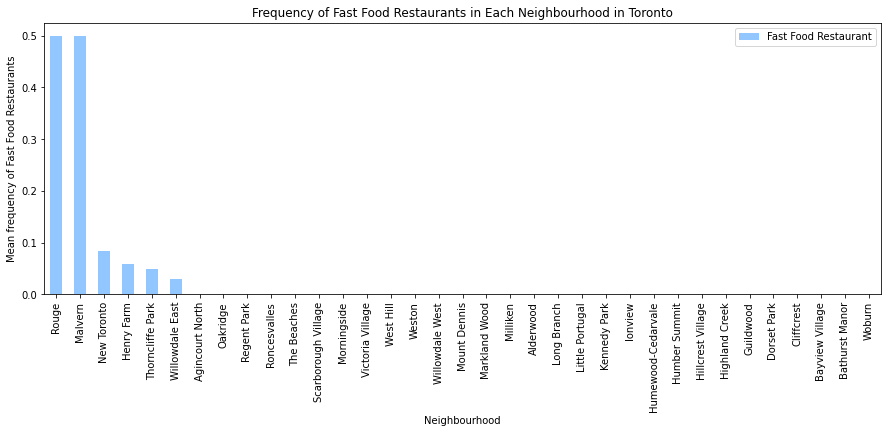

In [20]:
grouped.sort_values(by='Fast Food Restaurant', ascending=False, inplace=True)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn-pastel')
grouped.plot(kind='bar', figsize=(15,5))

plt.title('Frequency of Fast Food Restaurants in Each Neighbourhood in Toronto')
plt.xlabel('Neighbourhood')
plt.ylabel('Mean frequency of Fast Food Restaurants')

plt.show()

Next, visualize the Filipino population distribution per neighborhood

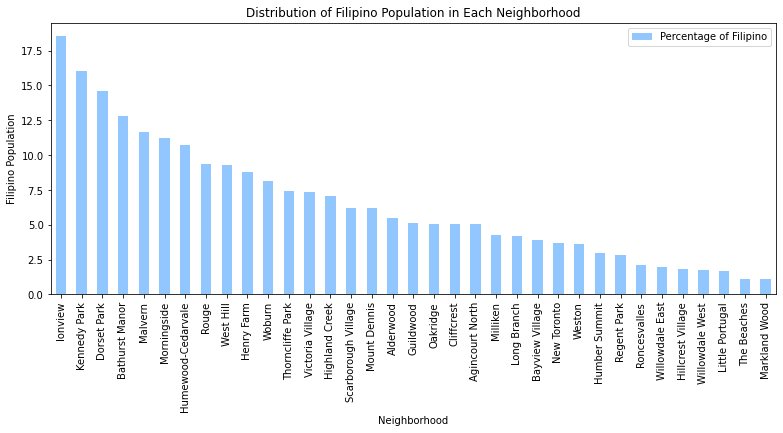

In [21]:
df_filipino = df[['Neighborhood', 'Percentage of Filipino']].set_index('Neighborhood')
df_filipino.sort_values(by='Percentage of Filipino', ascending=False, inplace=True)
df_filipino.plot(kind='bar', figsize=(13,5))

plt.title('Distribution of Filipino Population in Each Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Filipino Population')

plt.show()

Next, visualize the average income distribution per neighborhood

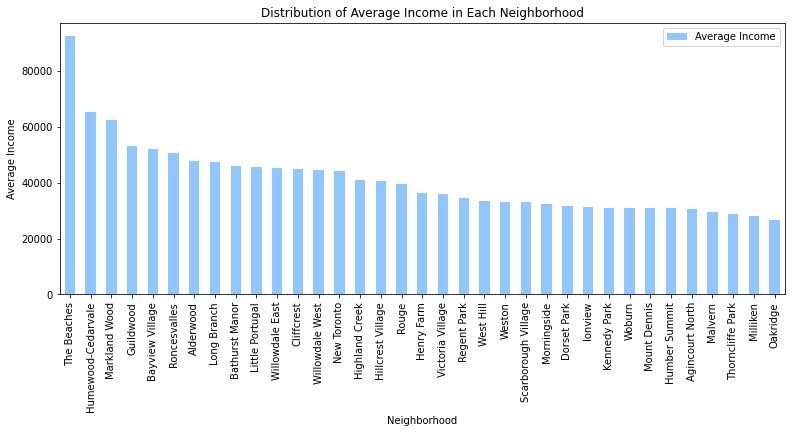

In [22]:
df_income = df[['Neighborhood', 'Average Income']].set_index('Neighborhood')
df_income.sort_values(by='Average Income', ascending=False, inplace=True)
df_income.plot(kind='bar', figsize=(13,5))

plt.title('Distribution of Average Income in Each Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Income')

plt.show()

In [23]:
final = pd.merge(df, grouped, on='Neighborhood')
final.head()

,Neighborhood,Latitude,Longitude,Average Income,Percentage of Filipino,Fast Food Restaurant
0,Victoria Village,43.725882,-79.315572,35786.0,7.367219,0.0
1,Regent Park,43.654260,-79.360636,34597.0,2.823290,0.0
2,Malvern,43.806686,-79.194353,29573.0,11.634014,0.5
3,Rouge,43.806686,-79.194353,39556.0,9.387904,0.5
4,Highland Creek,43.784535,-79.160497,40972.0,7.043381,0.0


## 3.3 Clustering the dataset

Let's start by normalizing the dataset.

In [24]:
from sklearn.preprocessing import StandardScaler


X = final.values[:,3:]
normalized_dataset = StandardScaler().fit_transform(X)
normalized_dataset

array([[-0.39073391,  0.19362245, -0.30102578],
       [-0.48183467, -0.84464415, -0.30102578],
       [-0.86677176,  1.16856526,  4.00832493],
       [-0.10187786,  0.65533971,  4.00832493],
       [ 0.00661556,  0.119627  , -0.30102578],
       [ 1.86862614,  0.95983189, -0.30102578],
       [ 1.64673565, -1.24077638, -0.30102578],
       [ 0.94375042, -0.3261937 , -0.30102578],
       [-0.65851957,  1.08253803, -0.30102578],
       [-0.5794481 ,  0.63320526, -0.30102578],
       [ 3.96080213, -1.23548054, -0.30102578],
       [-0.76678313,  0.36649159, -0.30102578],
       [-0.03399285, -1.07146079, -0.30102578],
       [ 0.38695547,  1.43247716, -0.30102578],
       [-0.92025227,  0.204369  ,  0.12990929],
       [-0.61086215, -0.06882976, -0.30102578],
       [-0.34683086,  0.5157397 ,  0.21352356],
       [ 0.37170816, -1.10792363, -0.30102578],
       [-0.75942764,  2.17994416, -0.30102578],
       [-0.72809021,  2.75653199, -0.30102578],
       [ 0.85425868, -0.60336679, -0.301

In [25]:
normalized = pd.DataFrame(normalized_dataset)
normalized.rename(columns={0:'Average Income', 1:'% Filipino', 2:'No. of Fast Food Restaurants'}, inplace=True)
normalized.head()

,Average Income,% Filipino,No. of Fast Food Restaurants
0,-0.390734,0.193622,-0.301026
1,-0.481835,-0.844644,-0.301026
2,-0.866772,1.168565,4.008325
3,-0.101878,0.655340,4.008325
4,0.006616,0.119627,-0.301026


### 3.3.1 The optimal `k` for clustering

/Users/cube/.local/share/virtualenvs/Coursera_Capstone-_E-QZ5IB/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/cube/.local/share/virtualenvs/Coursera_Capstone-_E-QZ5IB/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:>, k=None, model=None)

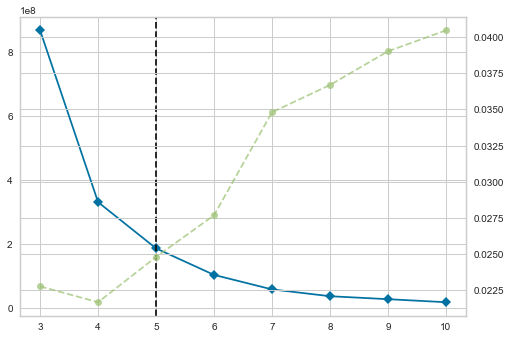

In [26]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,11))

visualizer.fit(X)
visualizer

Using the elbow method, it looks like the best `k` to use is 5.

### 3.3.2 Clustering the Toronto Neighborhood Using K-Means with K = 5

In [27]:
K = 5
kmeans = KMeans(n_clusters=K, random_state=0).fit(normalized)
kmeans.labels_

array([1, 1, 2, 2, 1, 0, 0, 0, 4, 1, 3, 1, 0, 4, 1, 1, 1, 0, 4, 4, 0, 1,
       1, 0, 1, 0, 1, 4, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

In [28]:
normalized['Cluster Label'] = kmeans.labels_
normalized.head()

,Average Income,% Filipino,No. of Fast Food Restaurants,Cluster Label
0,-0.390734,0.193622,-0.301026,1
1,-0.481835,-0.844644,-0.301026,1
2,-0.866772,1.168565,4.008325,2
3,-0.101878,0.655340,4.008325,2
4,0.006616,0.119627,-0.301026,1


In [29]:
clustered_df = pd.merge(df, normalized, left_index=True, right_index=True)
clustered_df.head()

,Neighborhood,Latitude,Longitude,Average Income_x,Percentage of Filipino,Average Income_y,% Filipino,No. of Fast Food Restaurants,Cluster Label
0,Victoria Village,43.725882,-79.315572,35786.0,7.367219,-0.390734,0.193622,-0.301026,1
1,Regent Park,43.654260,-79.360636,34597.0,2.823290,-0.481835,-0.844644,-0.301026,1
2,Malvern,43.806686,-79.194353,29573.0,11.634014,-0.866772,1.168565,4.008325,2
3,Rouge,43.806686,-79.194353,39556.0,9.387904,-0.101878,0.655340,4.008325,2
4,Highland Creek,43.784535,-79.160497,40972.0,7.043381,0.006616,0.119627,-0.301026,1


#### 3.3.2.1 Visualizing the clusters using Folium

In [30]:

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)

# set color schemes for the clusters
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(clustered_df['Latitude'], clustered_df['Longitude'], clustered_df['Neighborhood'], clustered_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [31]:
clustered_df.drop(['Average Income_y', '% Filipino'], axis=1, inplace=True)

#### 3.3.2.2 Examining the clusters

In [32]:
clustered_df.loc[clustered_df['Cluster Label'] == 0]

,Neighborhood,Latitude,Longitude,Average Income_x,Percentage of Filipino,No. of Fast Food Restaurants,Cluster Label
5,Humewood-Cedarvale,43.693781,-79.428191,65274.0,10.720501,-0.301026,0
6,Markland Wood,43.643515,-79.577201,62378.0,1.089634,-0.301026,0
7,Guildwood,43.763573,-79.188711,53203.0,5.092266,-0.301026,0
12,Hillcrest Village,43.803762,-79.363452,40442.0,1.830637,-0.301026,0
17,Little Portugal,43.647927,-79.419750,45737.0,1.671059,-0.301026,0
20,Bayview Village,43.786947,-79.385975,52035.0,3.879230,-0.301026,0
23,Cliffcrest,43.716316,-79.239476,44718.0,5.051773,-0.301026,0
25,Willowdale East,43.770120,-79.408493,45326.0,2.002617,-0.047535,0
28,Willowdale West,43.782736,-79.442259,44576.0,1.741852,-0.301026,0
29,Roncesvalles,43.648960,-79.456325,50580.0,2.103646,-0.301026,0


In [33]:
clustered_df.loc[clustered_df['Cluster Label'] == 1]

,Neighborhood,Latitude,Longitude,Average Income_x,Percentage of Filipino,No. of Fast Food Restaurants,Cluster Label
0,Victoria Village,43.725882,-79.315572,35786.0,7.367219,-0.301026,1
1,Regent Park,43.654260,-79.360636,34597.0,2.823290,-0.301026,1
4,Highland Creek,43.784535,-79.160497,40972.0,7.043381,-0.301026,1
9,West Hill,43.763573,-79.188711,33323.0,9.291034,-0.301026,1
11,Woburn,43.770992,-79.216917,30878.0,8.123773,-0.301026,1
14,Thorncliffe Park,43.705369,-79.349372,28875.0,7.414251,0.129909,1
15,Scarborough Village,43.744734,-79.239476,32913.0,6.218608,-0.301026,1
16,Henry Farm,43.778517,-79.346556,36359.0,8.776951,0.213524,1
21,Oakridge,43.711112,-79.284577,26793.0,5.055977,-0.301026,1
22,Humber Summit,43.756303,-79.565963,30731.0,2.939755,-0.301026,1


In [34]:
clustered_df.loc[clustered_df['Cluster Label'] == 2]

,Neighborhood,Latitude,Longitude,Average Income_x,Percentage of Filipino,No. of Fast Food Restaurants,Cluster Label
2,Malvern,43.806686,-79.194353,29573.0,11.634014,4.008325,2
3,Rouge,43.806686,-79.194353,39556.0,9.387904,4.008325,2


In [35]:
clustered_df.loc[clustered_df['Cluster Label'] == 3]

,Neighborhood,Latitude,Longitude,Average Income_x,Percentage of Filipino,No. of Fast Food Restaurants,Cluster Label
10,The Beaches,43.676357,-79.293031,92580.0,1.112811,-0.301026,3


In [36]:
clustered_df.loc[clustered_df['Cluster Label'] == 4]

,Neighborhood,Latitude,Longitude,Average Income_x,Percentage of Filipino,No. of Fast Food Restaurants,Cluster Label
8,Morningside,43.763573,-79.188711,32291.0,11.257519,-0.301026,4
13,Bathurst Manor,43.754328,-79.442259,45936.0,12.789013,-0.301026,4
18,Kennedy Park,43.727929,-79.262029,30974.0,16.060270,-0.301026,4
19,Ionview,43.727929,-79.262029,31383.0,18.583682,-0.301026,4
27,Dorset Park,43.757410,-79.273304,31692.0,14.638243,-0.301026,4
